(clv_quickstart)=
# CLV Quickstart

```{note}
This quickstart mirrors that of [lifetimes](https://lifetimes.readthedocs.io/en/latest/Quickstart.html). Several pictures and descriptions are directly attributable to the lifetimes developers.
```

In the following examples, we will use a dataset from an ecommerce provider to analyze their customers' repeat purchases. The dataset is available through the `lifetimes` package.

## The shape of your data

For all models, the following nomenclature is used:

* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases;
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks;
* `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;
* `monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from arviz.labels import MapLabeller

from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

from pymc_marketing import clv

In [2]:
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

In [3]:
data = load_cdnow_summary_data_with_monetary_value()
data

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00
...,...,...,...,...
2353,0,0.00,27.00,0.00
2354,5,24.29,27.00,44.93
2355,0,0.00,27.00,0.00


## Basic Frequency/Recency analysis using the BG/NBD model

We will use the BG/NBD model to infer the frequency of repeat purchases for all customers in the dataset.

In [4]:
bgm = clv.BetaGeoModel(
    customer_id=data.index, 
    frequency=data["frequency"],
    recency=data["recency"], 
    T=data["T"]
)

This model has 4 parameters that specify the global frequency and dropout rates of customers.

In [5]:
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

The default priors for the 4 parameters follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10.

In [6]:
bgm = clv.BetaGeoModel(
    customer_id=data.index, 
    frequency=data["frequency"],
    recency=data["recency"], 
    T=data["T"],
    a_prior=pm.HalfNormal.dist(10),
    b_prior=pm.HalfNormal.dist(10),
    alpha_prior=pm.HalfNormal.dist(10),
    r_prior=pm.HalfNormal.dist(10),
)
bgm

BG/NBD
         a ~ N**+(0, 10)
         b ~ N**+(0, 10)
     alpha ~ N**+(0, 10)
         r ~ N**+(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

Having specified the model, we can now fit it.

In [7]:
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.968,0.278,0.517,1.462,0.008,0.006,1359.0,1322.0,1.0
b,3.163,1.156,1.432,5.290,0.034,0.025,1340.0,1246.0,1.0
alpha,4.465,0.377,3.746,5.121,0.009,0.006,1852.0,2458.0,1.0
r,0.244,0.012,0.220,0.266,0.000,0.000,1996.0,2246.0,1.0


We can use [ArviZ](https://python.arviz.org/en/stable/), a Python library tailored to produce visualizations for Bayesian models, to plot the posterior distribution of each parameter.

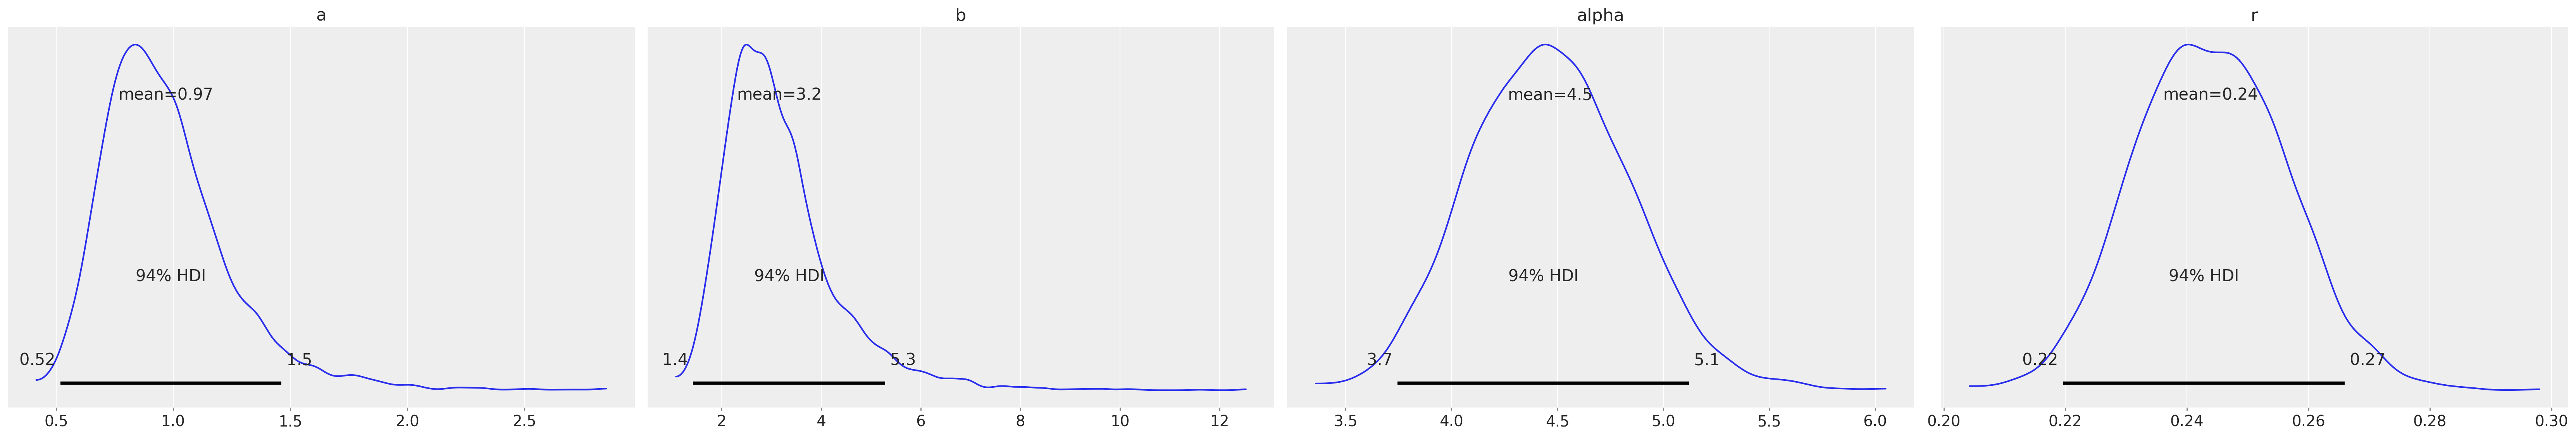

In [8]:
az.plot_posterior(bgm.fit_result);

### Visualizing the Frequency/Recency Matrix

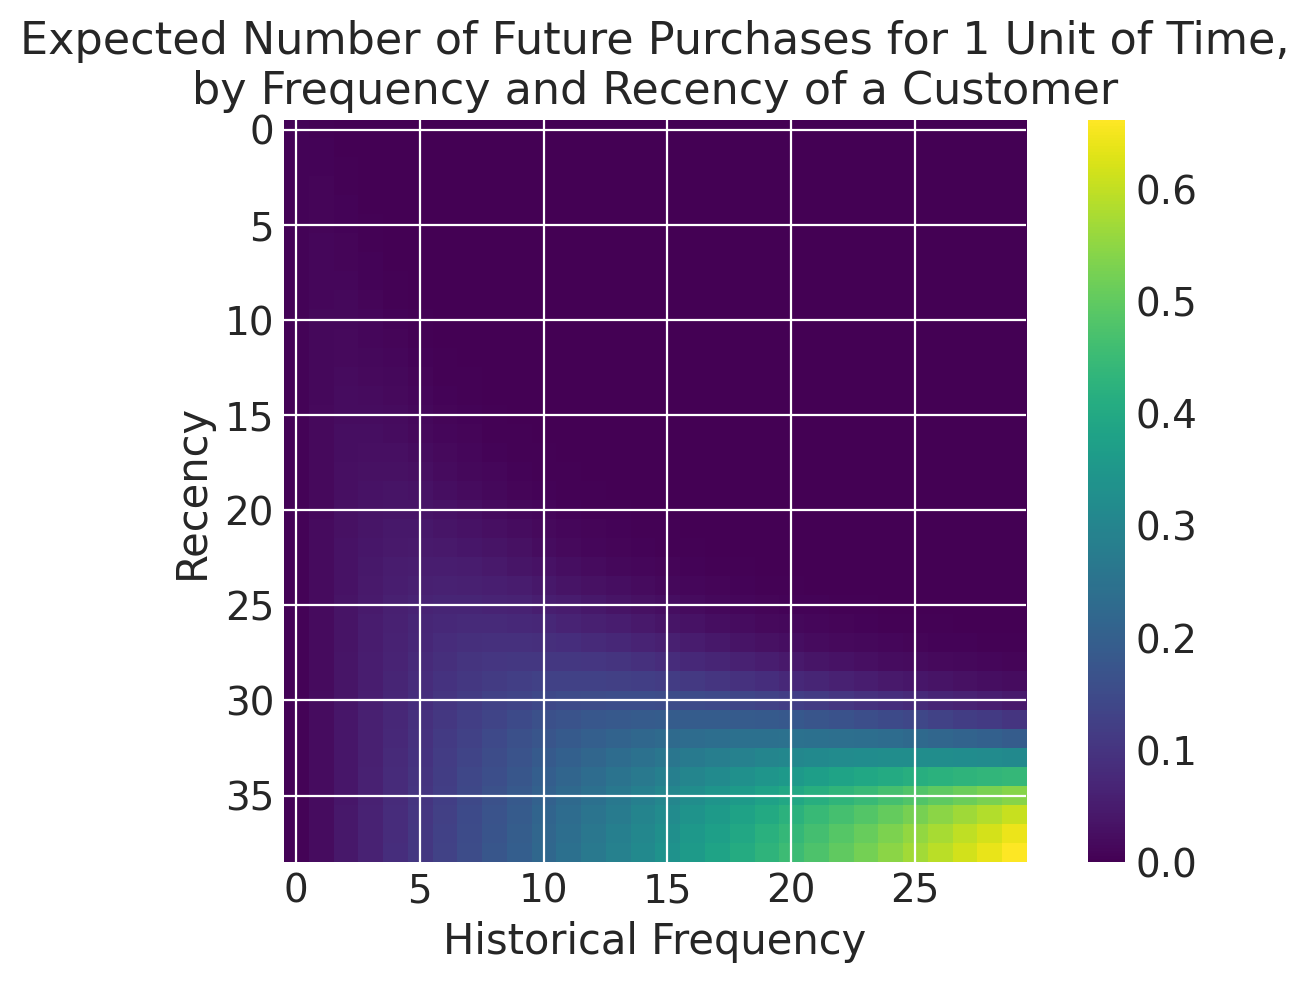

In [9]:
clv.plot_frequency_recency_matrix(bgm);

We can see that, if a customer has made 25 purchases and their latest purchase was when they were 35 weeks old (given the individual is 35 weeks old), then they are your best customer (bottom-right). Your "coldest" customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

Note that there is also that beautiful “tail” around (5, 25). This represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

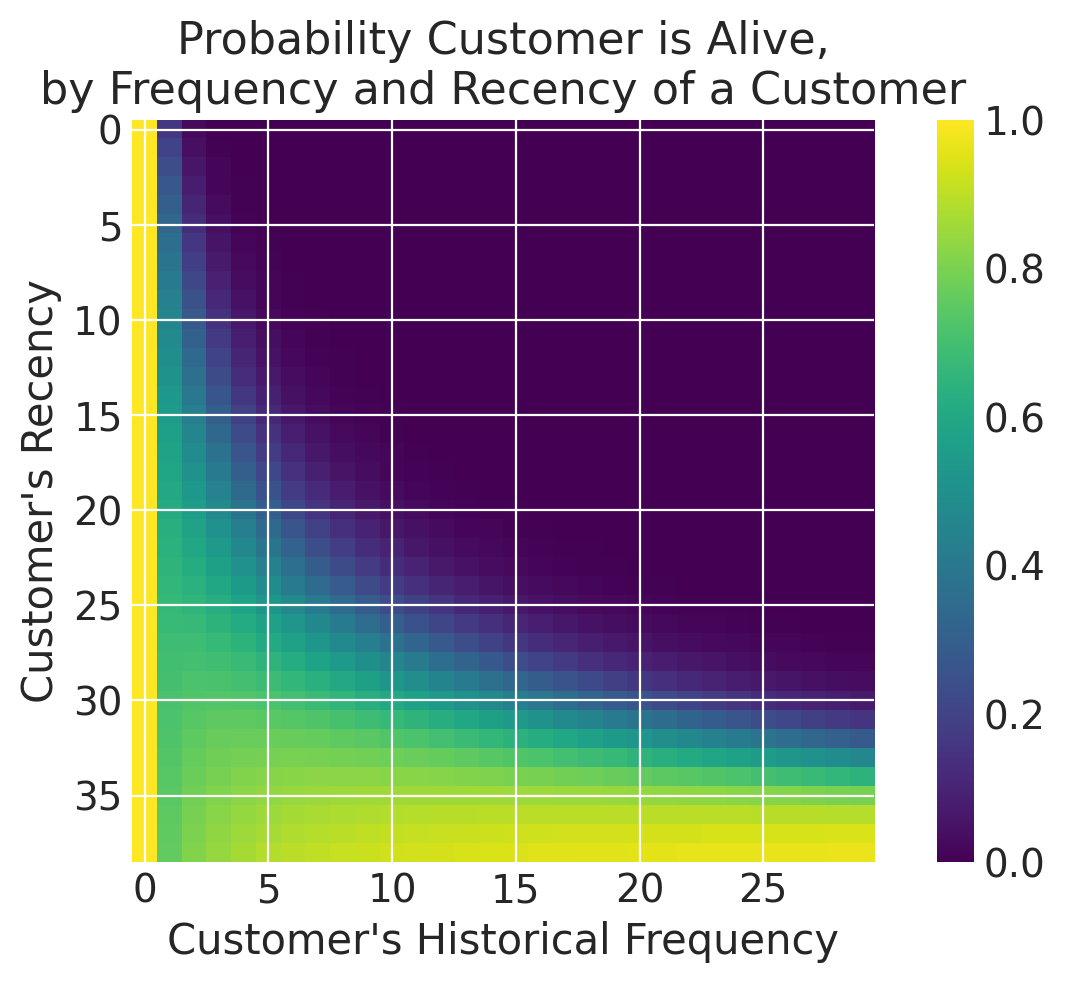

In [10]:
clv.plot_probability_alive_matrix(bgm);

Looking at the probability alive matrix, we can infer that users who have made a lot of purchases a long time ago are likely to never return.

### Ranking customers from best to worst

Having fit the model, we can ask what is the expected number of purchases for our customers in the next period. Let's look at the five more promising customers.

In [11]:
num_purchases = bgm.expected_num_purchases(
    customer_id=data.index,
    t=1, 
    frequency=data["frequency"], 
    recency=data["recency"], 
    T=data["T"]
)

In [12]:
sdata = data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,frequency,recency,T,monetary_value,expected_purchases
customer_id,,,,,
841,19,34.00,34.14,29.49,0.470456
1981,17,28.43,28.86,48.23,0.481270
157,29,37.71,38.00,26.26,0.657057
1516,26,30.86,31.00,39.97,0.704642


We can plot the uncertainty in the expected number of purchases in the next period.

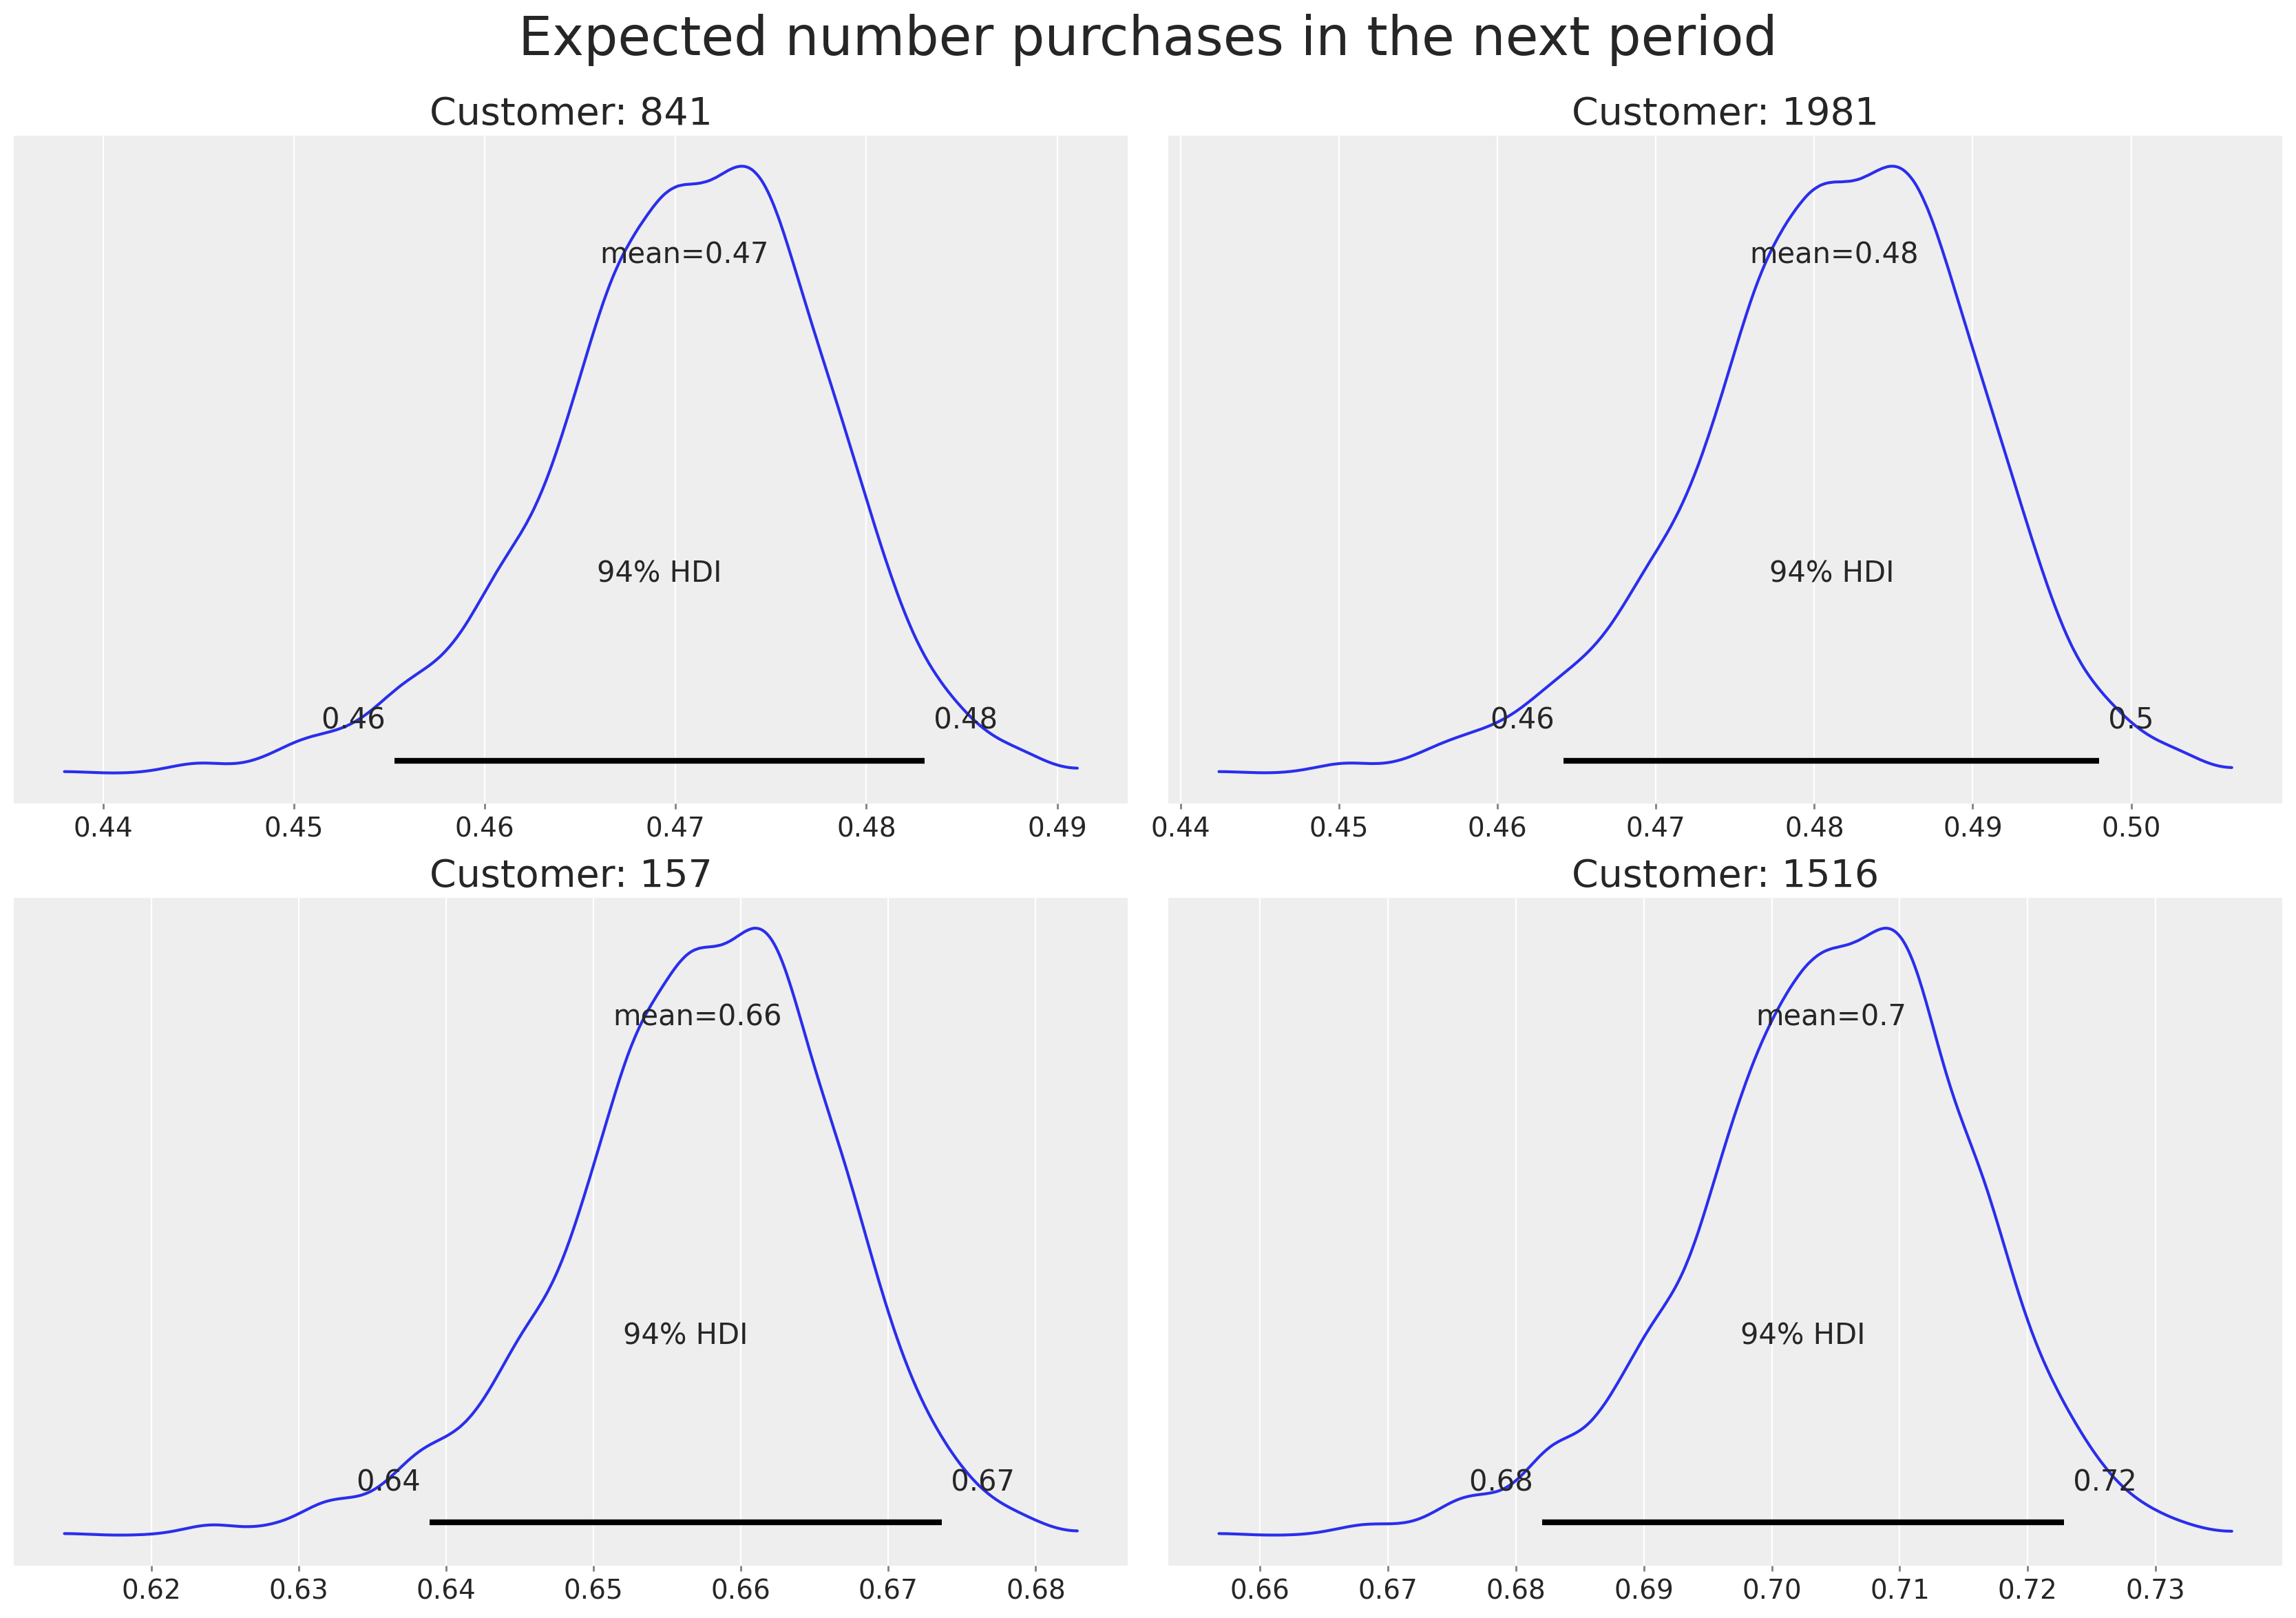

In [13]:
ids = [841, 1981, 157, 1516]
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));
for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05);

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

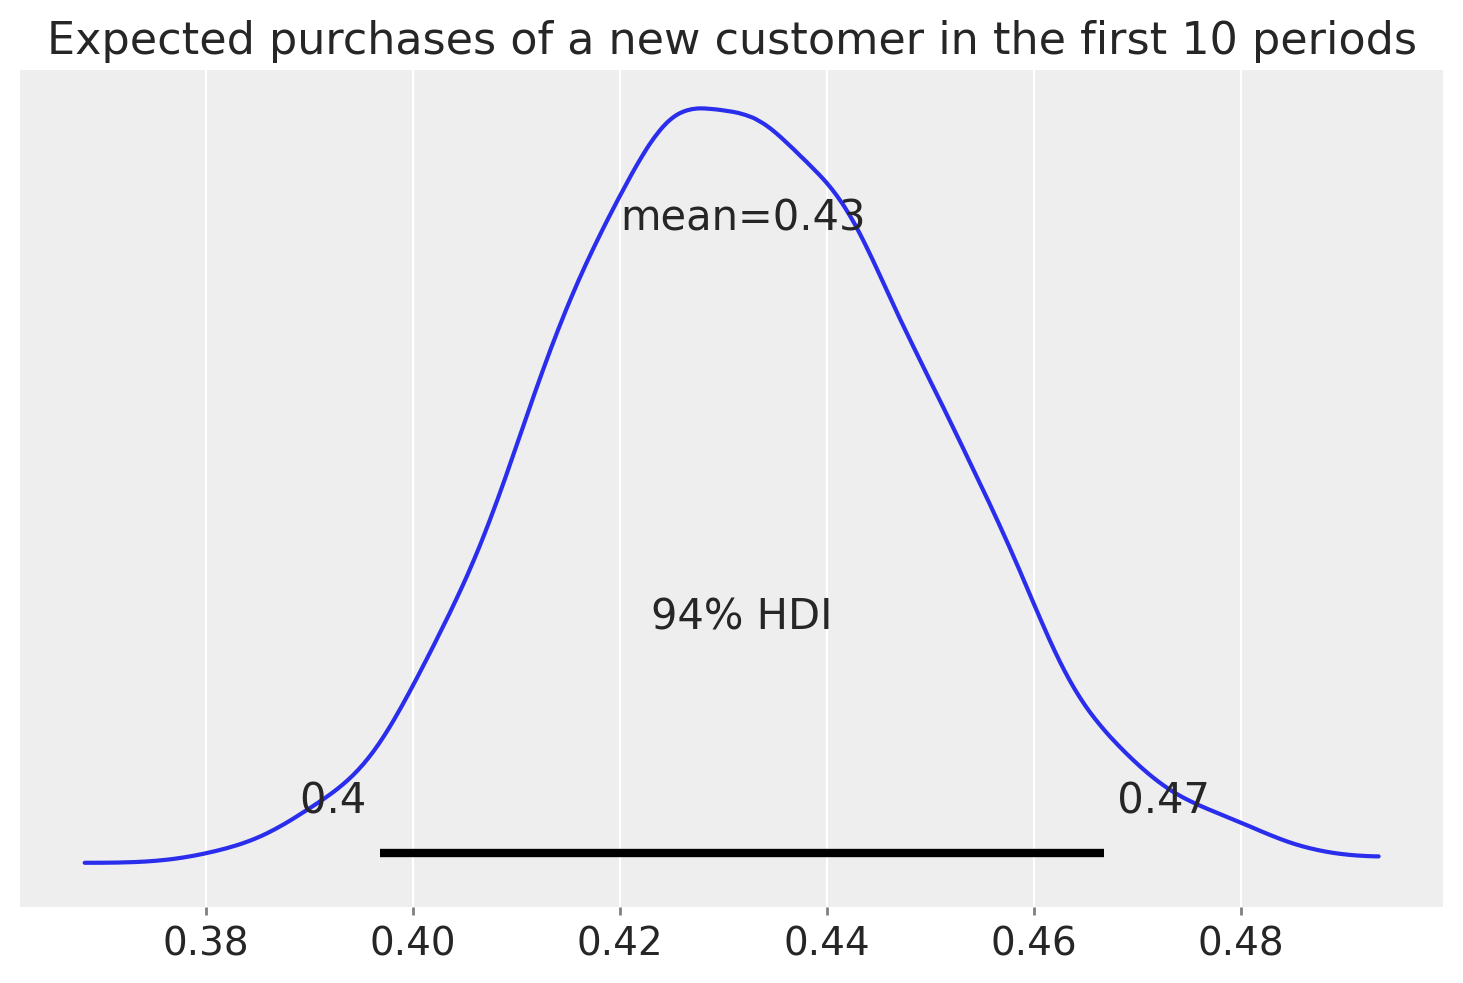

In [14]:
az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=10)
);
plt.title("Expected purchases of a new customer in the first 10 periods");

### Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. 

Let look at active customer 1516 and assess the change in probability that the user will ever return if they do no other purchases in the next 9 time periods.

In [15]:
customer_1516 = data.loc[1516]
customer_1516

frequency         26.00
recency           30.86
T                 31.00
monetary_value    39.97
Name: 1516, dtype: float64

In [16]:
customer_1516_history = pd.DataFrame(dict(
    ID=np.full(10, 1516, dtype="int"),
    frequency=np.full(10, customer_1516["frequency"], dtype="int"),
    recency=np.full(10, customer_1516["recency"]),
    T=(np.arange(-1, 9) + customer_1516["T"]).astype("int"),
    
))
customer_1516_history

,ID,frequency,recency,T
0,1516,26,30.86,30
1,1516,26,30.86,31
2,1516,26,30.86,32
3,1516,26,30.86,33
4,1516,26,30.86,34
5,1516,26,30.86,35
6,1516,26,30.86,36
7,1516,26,30.86,37
8,1516,26,30.86,38
9,1516,26,30.86,39


In [17]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_1516_history["ID"],
    frequency=customer_1516_history["frequency"],
    recency=customer_1516_history["recency"],
    T=customer_1516_history["T"],
)

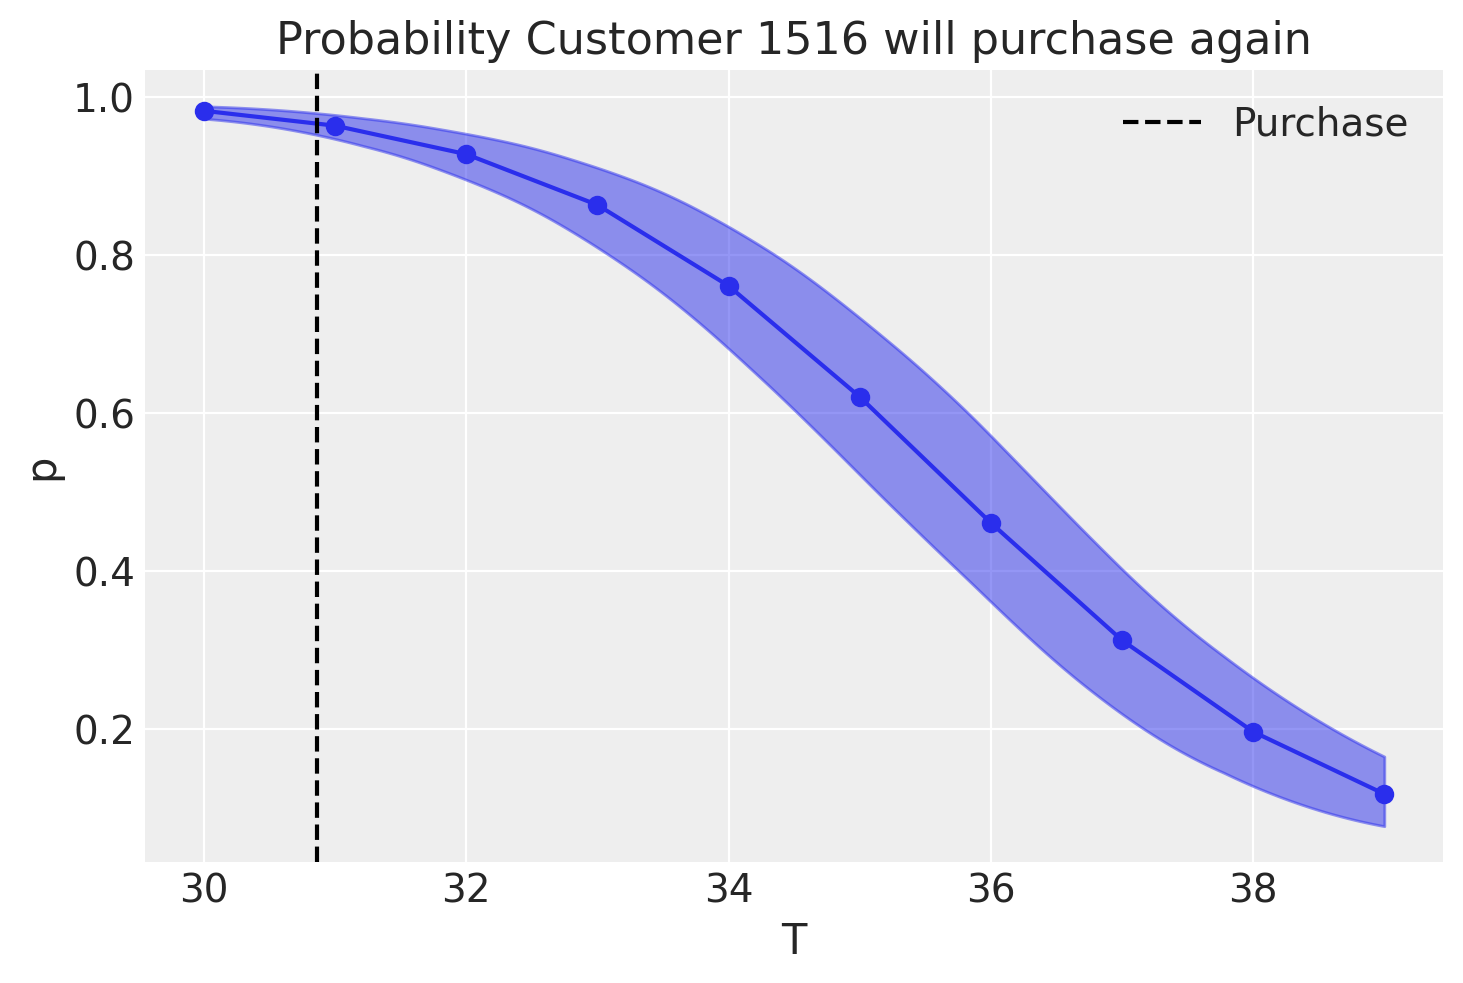

In [18]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

We can see that, if no purchases are being made in the next 9 weeks, the model has low confidence that the costumer will ever return. What if they had done one purchase in between?

In [19]:
customer_1516_history["frequency"].iloc[-3:] += 1
customer_1516_history["recency"].iloc[-3:] = customer_1516_history["T"].iloc[-3] - 0.5
customer_1516_history

,ID,frequency,recency,T
0,1516,26,30.86,30
1,1516,26,30.86,31
2,1516,26,30.86,32
3,1516,26,30.86,33
4,1516,26,30.86,34
5,1516,26,30.86,35
6,1516,26,30.86,36
7,1516,27,36.50,37
8,1516,27,36.50,38
9,1516,27,36.50,39


In [20]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_1516_history["ID"],
    frequency=customer_1516_history["frequency"],
    recency=customer_1516_history["recency"],
    T=customer_1516_history["T"],
)

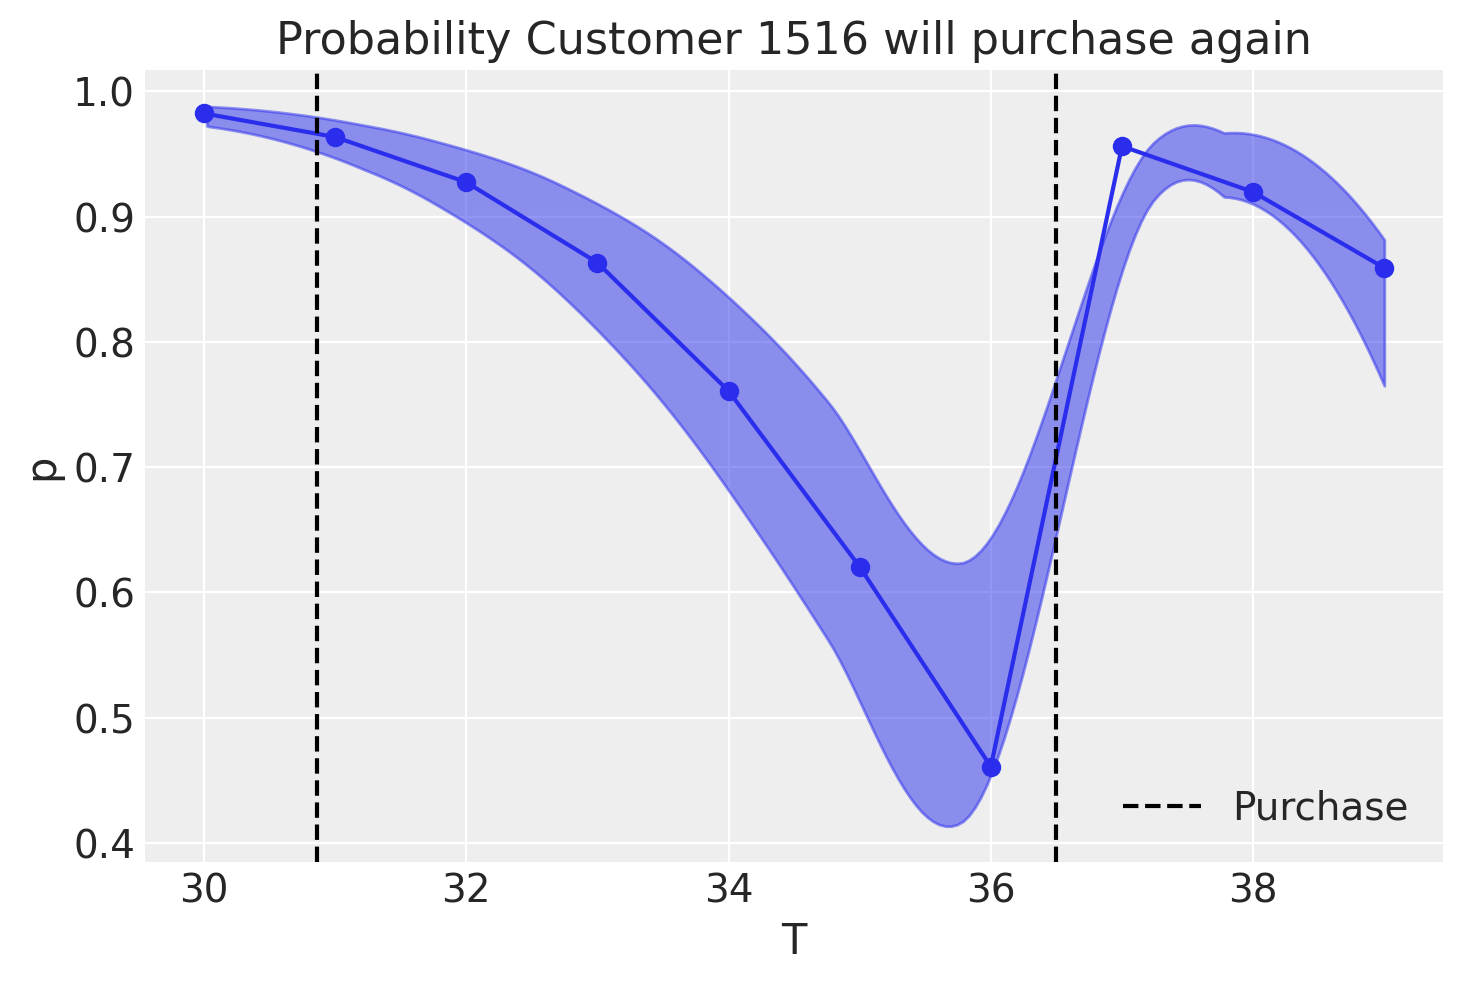

In [21]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")
plt.axvline(customer_1516_history["recency"].iloc[-1], c="black", ls="--")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

From the plot above, say that customer 1516 makes a purchase at week 36.5, roughly ~6 weeks after they have made their last recorded purchase at time 30.86 weeks according to the data. We can see that the probability of the customer returning quickly goes back up!

In other words, for every purchase, the probability of a customer returning for a/more purchase(s) increases. Similarly, as time goes by where a customer makes no purchase, the likelihood of them returning for a purchases decreases with time.

## Estimating customer lifetime value using the Gamma-Gamma model

In the analysis above, we did not take into account the monetary value of each transaction as we only focused on transactions’ occurrences. To estimate transaction values, we can use the Gamma-Gamma model. To do so, we need a summary data of the economic values for each transaction (i.e. profits or revenues).

This model assumes at least 1 transaction has been observed per customer. As such we filter out those with zero repeat purchases.

In [22]:
nonzero_data = data.query("frequency>0")
nonzero_data

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55
...,...,...,...,...
2348,7,24.14,27.00,16.36
2349,1,9.29,27.00,13.97
2350,2,21.86,27.00,18.56


The Gamma-Gamma model has 3 parameters that specify the group expected mean spend and expected individual variation around that mean. As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [23]:
gg = clv.GammaGammaModel(
    customer_id=nonzero_data.index,
    mean_transaction_value=nonzero_data["monetary_value"],
    frequency=nonzero_data["frequency"],
)
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

By default, `fit` approximates full Bayesian posterior using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling provided by `pymc.sample`. If the full posterior is not needed or MCMC sampling is too slow, users can obtain the single [maximum a posteriori estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) via the `fit_method` kwarg.

In [24]:
gg.fit(fit_method="map");

In [25]:
gg.fit_summary()

p     6.249
q     3.745
v    15.448
Name: value, dtype: float64

In [26]:
gg.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
/home/ricardo/Documents/Work/Labs/pymmmc/pymc_marketing/clv/models/basic.py:92: UserWarning: Overriding pre-existing fit_result
  warnings.warn("Overriding pre-existing fit_result")


In [27]:
gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.439,1.315,4.315,9.041,0.046,0.033,855.0,1132.0,1.0
q,3.791,0.299,3.227,4.354,0.010,0.007,879.0,1192.0,1.0
v,16.022,4.363,8.407,24.174,0.154,0.109,778.0,1039.0,1.0


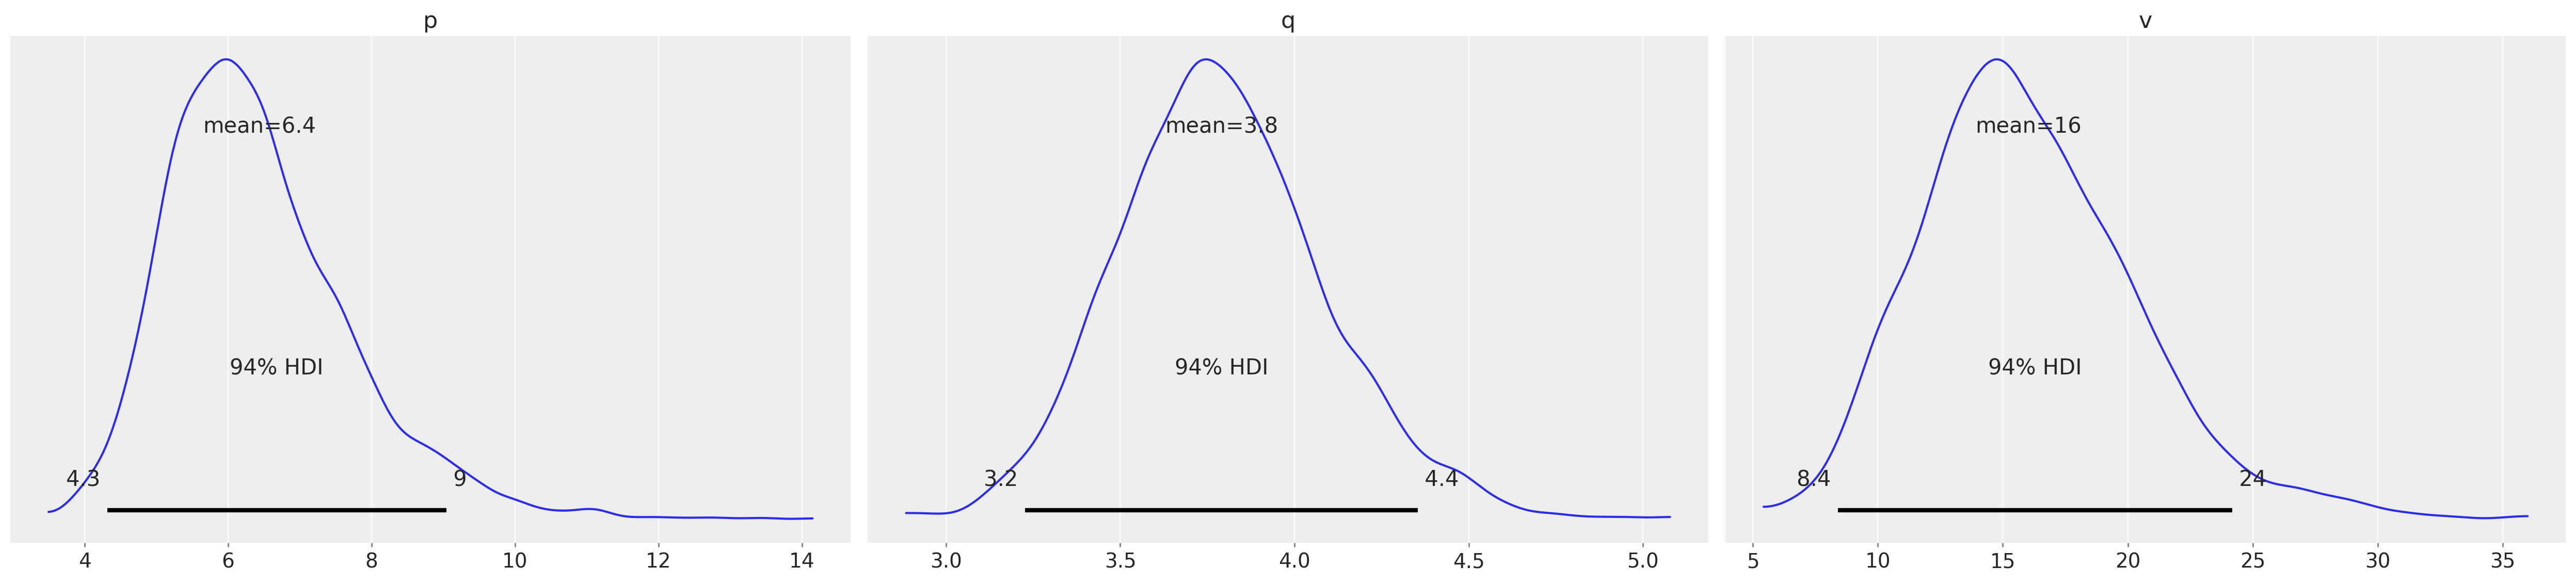

In [28]:
az.plot_posterior(gg.fit_result);

### Predicting spend value of customers

Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [29]:
expected_spend = gg.expected_customer_spend(
    customer_id=data.index,
    mean_transaction_value=data["monetary_value"],
    frequency=data["frequency"],
)

In [30]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],24.694,0.517,23.712,25.626
x[2],18.971,1.328,16.536,21.513
x[3],35.152,0.931,33.521,36.987
x[4],35.152,0.931,33.521,36.987
x[5],35.152,0.931,33.521,36.987
x[6],71.385,0.621,70.244,72.549
x[7],18.971,1.328,16.536,21.513
x[8],35.152,0.931,33.521,36.987
x[9],27.307,0.395,26.554,28.016
x[10],35.152,0.931,33.521,36.987


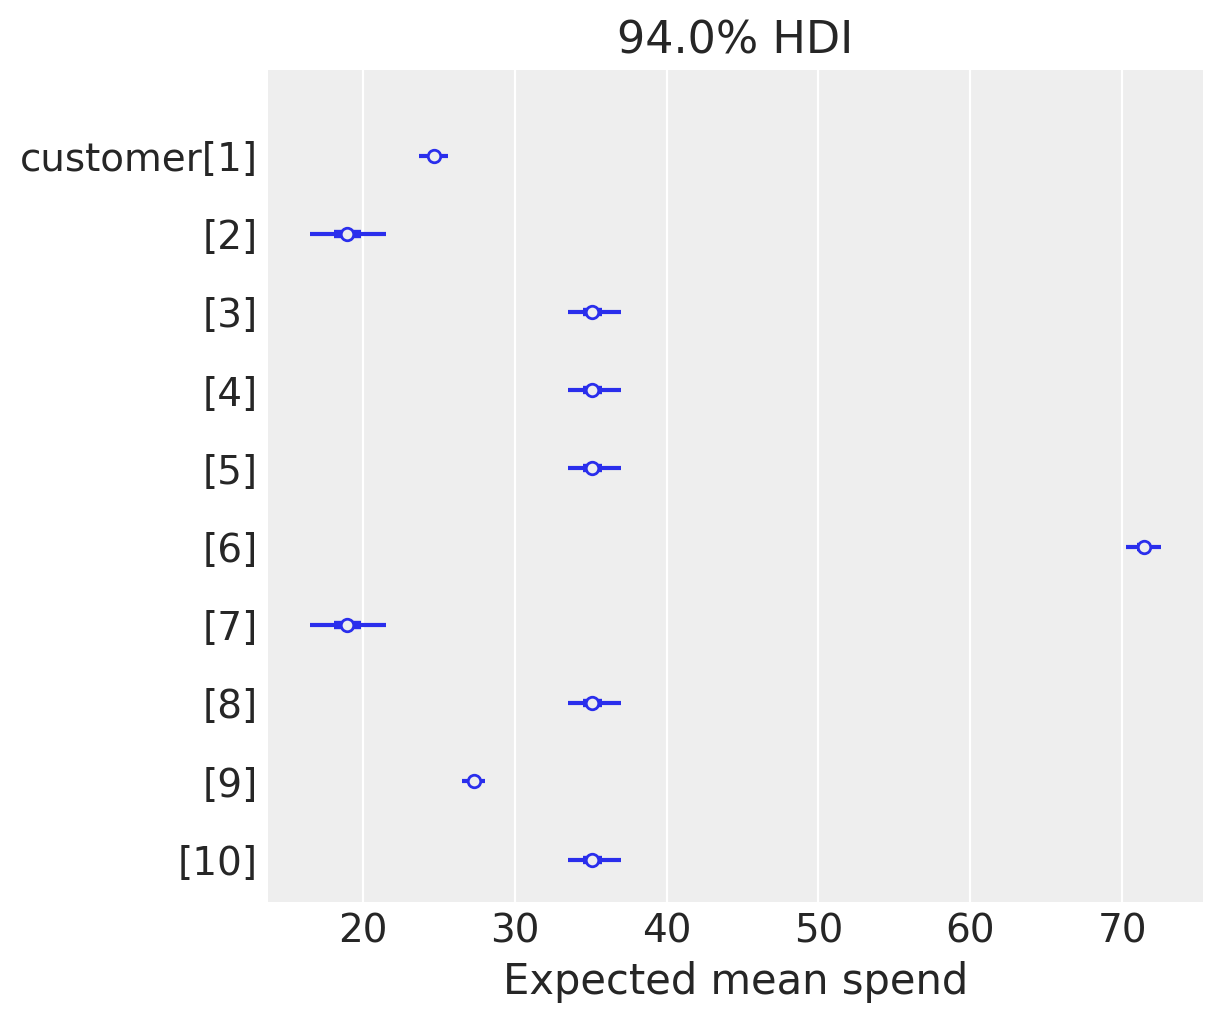

In [31]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)
plt.xlabel("Expected mean spend");

We can also look at the average expected mean spend across all customers

In [32]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.237,0.632,34.155,36.494


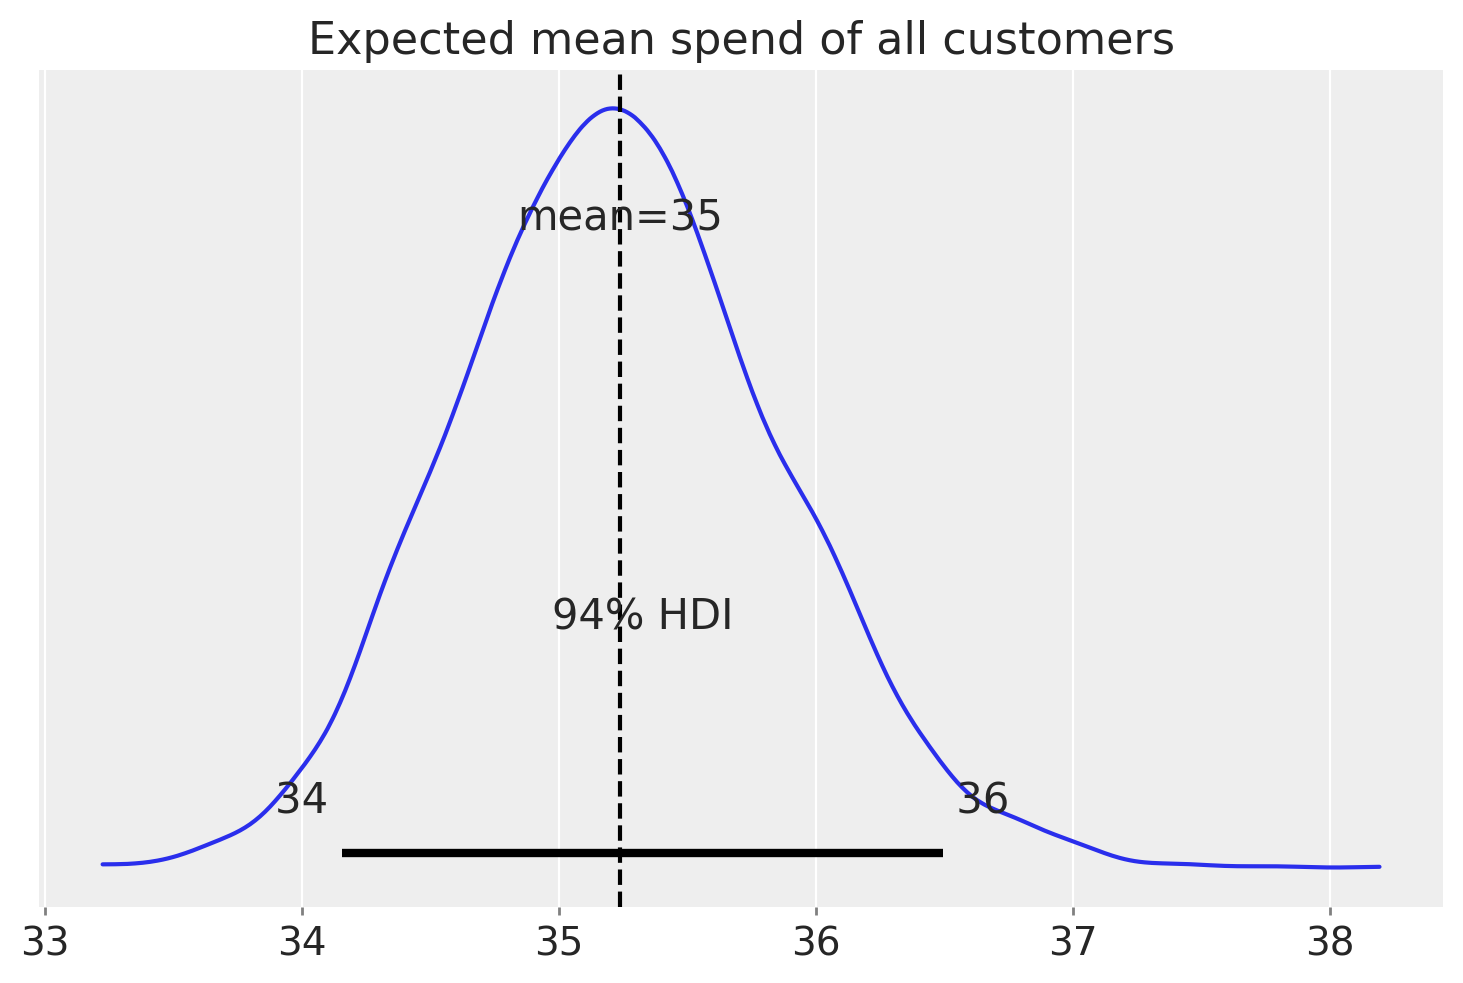

In [33]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");

### Predicting spend value of a new customer

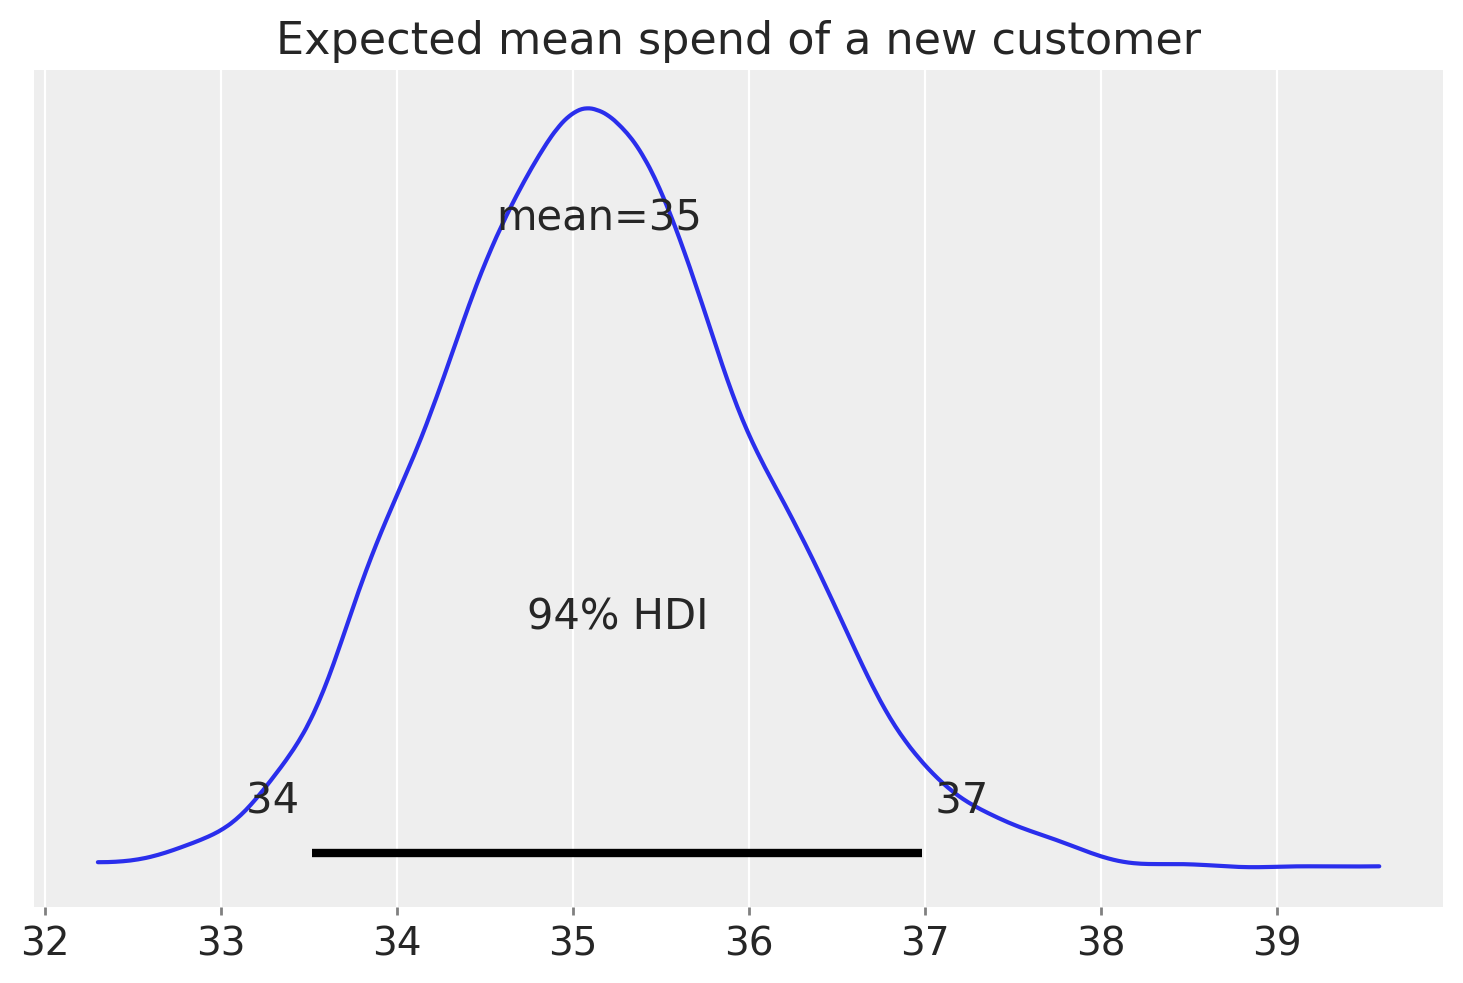

In [34]:
az.plot_posterior(
    gg.expected_new_customer_spend()
)
plt.title("Expected mean spend of a new customer");

### Estimating CLV

Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the [Discounted cash flow](https://en.wikipedia.org/wiki/Discounted_cash_flow) model, adjusting for cost of capital:

In [35]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=data.index,
    mean_transaction_value=data["monetary_value"],
    frequency=data["frequency"],
    recency=data["recency"],
    T=data["T"],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq="W", # Our original data is in weeks
)

In [36]:
az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],35.966,1.647,32.775,38.917
x[2],4.843,0.626,3.749,6.088
x[3],8.395,0.447,7.545,9.198
x[4],8.395,0.447,7.545,9.198
x[5],8.395,0.447,7.545,9.198
x[6],266.861,29.364,213.699,322.899
x[7],7.124,0.797,5.700,8.713
x[8],8.395,0.447,7.545,9.198
x[9],42.953,1.676,39.763,46.030
x[10],8.395,0.447,7.545,9.198


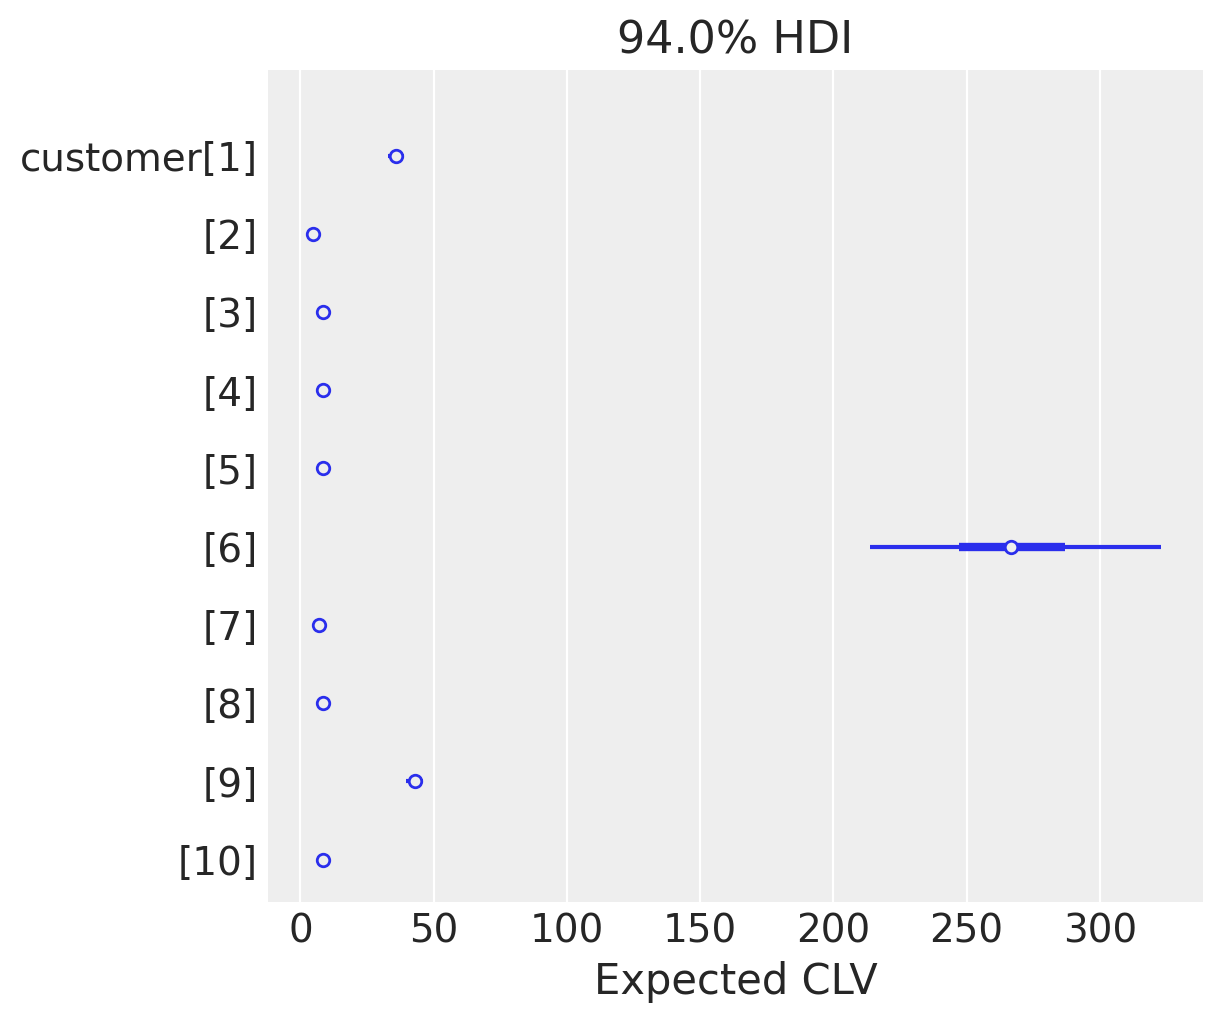

In [37]:
az.plot_forest(clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller)
plt.xlabel("Expected CLV");

According to our models, customer 6 has a much higher expected CLV. There is also a large variability in this estimate that arises solely from uncertainty in the parameters of the BG/NBD and GG models. 

In general, these models tend to induce a strong correlation between expected CLV and uncertainty. This modelling of uncertainty can be very useful when making marketing decisions.